In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
from scipy.stats import linregress

Google Earth Engine (GEE) was used to access raw satellite data and manipulate it into a form that would not be memory intensive when downloaded. It did math manipulation then was downloaded as a csv, which was then uploaded to Jupyter and compared to other satellites/pandora in python. 

Code for GEE (special version of javascript) has been copied below. Copy it back into GEE to replicate what i've done. GEE requires a google account to sign in, but is free for non-commercial use at this time

General overview of time selection:
1) find times of sentinel overpass
2) tempo and pandora windows will be an average of all values found during a +- 30 min window of sentinel's overpass

This is due to sentinel being the most limited on overpasses

# CBBT

In [2]:
tempo_path = '../HULL/Data/TEMPO_CBBT_NO2_TimeSeries.csv'
sentinel_path = '../HULL/Data/TROPOMI_CBBT_NO2_TimeSeries.csv'

tempo = pd.read_csv(tempo_path)
sentinel = pd.read_csv(sentinel_path)

In [3]:
# create combined dataframe of tempo and sentinel
combined = pd.merge(tempo, sentinel, on='datetime') #datetime object is the same across both from GEE code

# rename and remove columns as needed to make a neat df
combined.drop(columns=['system:index_x', '.geo_x', 'system:index_y', '.geo_y'], inplace=True)
combined.rename(columns={'raw_NO2': 'tempo_NO2_raw', 'NO2':'sentinel_NO2'}, inplace=True)

# see combined df
combined.head()

,datetime,tempo_NO2_raw,tempo_NO2_scaled,sentinel_NO2
0,2024-07-01 17:05,4.237064e+15,0.000070,0.000080
1,2024-07-01 18:45,4.811190e+15,0.000080,0.000087
2,2024-07-02 18:25,NaN,NaN,0.000068
3,2024-07-02 18:30,NaN,NaN,NaN
4,2024-07-03 16:30,5.093194e+15,0.000085,NaN


In [6]:
# IQR Outliers for tempo
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined['tempo_NO2_scaled'].quantile(0.25)
Q3 = combined['tempo_NO2_scaled'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# remove outliers to get a cleaned version
cleaned = combined[(combined['tempo_NO2_scaled'] >= lower_bound) & (combined['tempo_NO2_scaled'] <= upper_bound)]



# IQR outliers for tropomi (sentinel)
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined['sentinel_NO2'].quantile(0.25)
Q3 = combined['sentinel_NO2'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# remove outliers to get a cleaned version
# add condition that tempo cleaned data must exists -> only compares datapoints where both satellites have a non-outlier reading
cleaned = combined[(combined['sentinel_NO2'] >= lower_bound) & (combined['sentinel_NO2'] <= upper_bound) & (cleaned['tempo_NO2_scaled'] != np.nan)]



print(cleaned)

            datetime  tempo_NO2_raw  tempo_NO2_scaled  sentinel_NO2
0   2024-07-01 17:05   4.237064e+15          0.000070      0.000080
1   2024-07-01 18:45   4.811190e+15          0.000080      0.000087
5   2024-07-03 18:05   5.376806e+15          0.000089      0.000086
6   2024-07-03 18:10   5.376806e+15          0.000089      0.000091
7   2024-07-04 17:50   5.473884e+15          0.000091      0.000099
8   2024-07-05 17:30   6.102449e+15          0.000101      0.000088
10  2024-07-06 17:10   4.259931e+15          0.000071      0.000094
11  2024-07-06 18:50   4.958516e+15          0.000082      0.000088
15  2024-07-07 18:35   5.178773e+15          0.000086      0.000083
18  2024-07-09 17:55   3.605036e+15          0.000060      0.000082
26  2024-07-14 18:00   4.879988e+15          0.000081      0.000079
28  2024-07-15 17:40   4.686018e+15          0.000078      0.000073
29  2024-07-15 17:45   4.686018e+15          0.000078      0.000072
31  2024-07-16 19:05   5.190157e+15          0.0

In [8]:
#Read in data for pandora
CBBT_NO2s_filepath = "../HULL/Data/Pandora255s1_VirginiaBeachVA-CBBT_L2_NO2s.txt"

#column names based on begining 70ish rows of the file, manually put in
col_names_NO2s = ["DateTime", "Time since 2000", "Duration of Measurement", "Solar Zenith", "Solar Azimuth", "Lunar Zenith", "Lunar Azimuth", "rms", "normalized rms", "Expected rms",
                   "expected normalized rms", "Climatological station pressure", "data processing type", "calibration file version", "calibration file validity starting date", "mean value of measured data", "wavelength effective temperature", "est avg residual stray light level", "retrieved wavelength shift from L1", "retrieved total wavelength shift",
                   "retrieved resolution change", "integration time", "number of bright count cycles", "effective position of filterwheel #1", "effective position of filterwheel #2", "atmospheric variability", "Estimated AOD at starting wavelength", "Estimated AOD at center wavelength", "Estimated aerosol optical depth at ending wavelength", "L1 quality flag",
                   "Sum over 2^i using those i L1 exceeds the DQ1 limit", "Sum over 2^i using those i L1 exceeds the DQ2 limit", "L2Fit quality flag", "Sum over 2^i using those i L2Fit exceeds the DQ1 limit", "Sum over 2^i using those i L2Fit exceeds the DQ2 limit", "L2 quality flag", "Sum over 2^i using those i L2 exceeds the DQ1 limit", "Sum over 2^i using those i L2 exceeds the DQ2 limit", "NO2 total vertical column amount", "Independent uncertainty of NO2 TC",
                   "Structured uncertainty of NO2 TC", "Common uncertainty of NO2 TC", "total uncertainty of NO2 TC", "rms-based uncertainty of NO2 TC", "NO2 effective temperature", "Independent undertainty of NO2 eff temp", "structured uncertainty of NO2 eff temp", "common uncertainty of NO2 eff temp", "Total uncertainty of NO2 eff temp", "Direct NO2 Air Mass Factor", 
                   "Uncertainty of direct NO2 AMF", "Diffuse correction", "Climatological NO2 stratospheric column amount", "Uncertainty of climatological NO2 strat amount"]

# has special encoding and must skip information rows to get to data
pandora=pd.read_csv(CBBT_NO2s_filepath, sep = " ",encoding='latin',on_bad_lines='warn', skiprows=77, names=col_names_NO2s)

In [9]:
# loop through to get data from pandora for each datastamp within a +-30min window of an overpass time
mean_TC_list = []
time_sec = []
for doi in combined['datetime']:
    j2000_epoch = datetime(2000, 1, 1, 0, 0)
    target_date = datetime.strptime(doi, "%Y-%m-%d %H:%M")
    delta = timedelta(minutes = 30)
    begin = target_date-delta
    end = target_date+delta
    
    # converts to seconds since 1/1/2000, which is what pandora measures in
    begin_seconds = (begin - j2000_epoch).total_seconds() / 86400
    end_seconds = (end - j2000_epoch).total_seconds() / 86400
    
    #select time window
    data = pandora[(pandora.iloc[:, col_names_NO2s.index("Time since 2000")].values >= begin_seconds)&(pandora.iloc[:, col_names_NO2s.index("Time since 2000")].values <= end_seconds)]
    #pulls out just the TC value
    TC = data.iloc[:, [col_names_NO2s.index("NO2 total vertical column amount")]].values
    #finds the mean in that window
    mean_TC = np.nanmean(TC)
    #adds mean and datetime to lists
    mean_TC_list.append(mean_TC)
    time_sec.append((target_date-j2000_epoch).total_seconds()/86400)
    
    
#adds the mean TC for each time as well as the time in seconds to the combined dataset
combined['pandora_NO2'] = mean_TC_list
combined['time_sec'] = time_sec

/tmp/ipykernel_302868/2009411799.py:20: RuntimeWarning: Mean of empty slice
  mean_TC = np.nanmean(TC)


In [10]:
# Cleans pandora based on IQR
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined['pandora_NO2'].quantile(0.25)
Q3 = combined['pandora_NO2'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Optionally, remove them to get a cleaned version
cleaned = combined[(combined['pandora_NO2'] >= lower_bound) & (combined['pandora_NO2'] <= upper_bound) & (cleaned['tempo_NO2_scaled'] != np.nan) & (cleaned['sentinel_NO2'] != np.nan)]


cleaned.head()

,datetime,tempo_NO2_raw,tempo_NO2_scaled,sentinel_NO2,pandora_NO2,time_sec
0,2024-07-01 17:05,4.237064e+15,0.000070,0.000080,0.000085,8948.711806
1,2024-07-01 18:45,4.811190e+15,0.000080,0.000087,0.000088,8948.781250
5,2024-07-03 18:05,5.376806e+15,0.000089,0.000086,0.000082,8950.753472
6,2024-07-03 18:10,5.376806e+15,0.000089,0.000091,0.000078,8950.756944
7,2024-07-04 17:50,5.473884e+15,0.000091,0.000099,0.000071,8951.743056


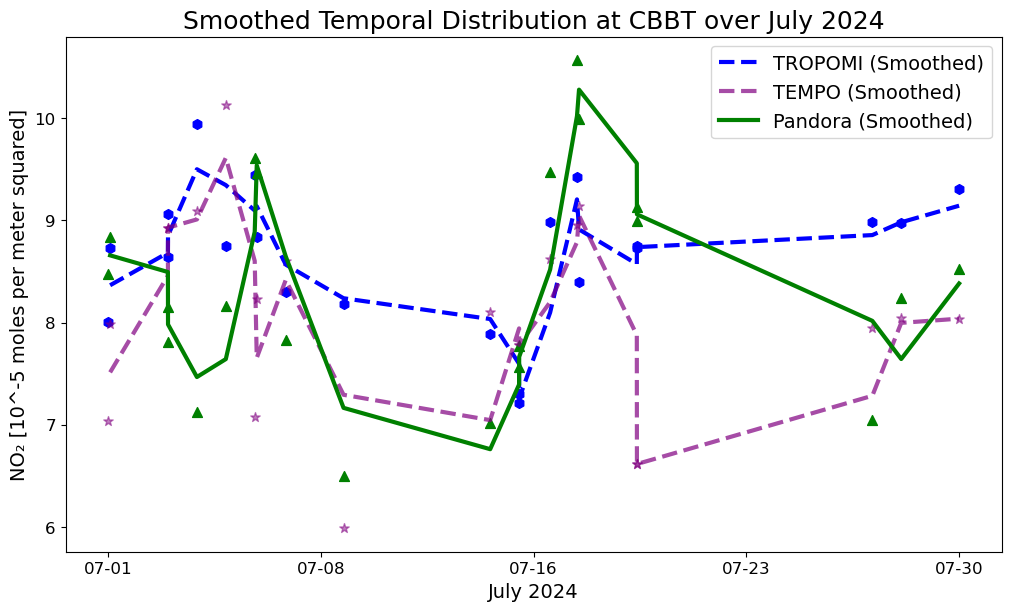

In [10]:
# smoothed temporal distribution plot
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# scatter plot the three by time
ax.scatter(cleaned['time_sec'], cleaned['sentinel_NO2']/10**-5, marker = 'h', color = 'blue', s = 50)
ax.scatter(cleaned['time_sec'], cleaned['tempo_NO2_scaled']/10**-5, marker = '*', alpha = .5, color = 'purple', s = 50)
ax.scatter(cleaned['time_sec'], cleaned['pandora_NO2']/10**-5, marker = '^', color = 'green', s = 50)

# uses a rolling window to see patterns in three methods
window = 2 # adjust for smoothness
ax.plot(cleaned['time_sec'], (cleaned['sentinel_NO2']/10**-5).rolling(window, center=True).mean(), color='blue', label='TROPOMI (Smoothed)', linestyle='--', linewidth = 3)
ax.plot(cleaned['time_sec'], (cleaned['tempo_NO2_scaled']/10**-5).rolling(window, center=True).mean(), color='purple', label='TEMPO (Smoothed)', alpha = .7, linestyle='--', linewidth = 3)
ax.plot(cleaned['time_sec'], (cleaned['pandora_NO2']/10**-5).rolling(window, center=True).mean(), color='green', label='Pandora (Smoothed)', linewidth = 3)

#makes axis look good, finishing touches
ax.set_xticks(np.linspace(cleaned['time_sec'].iloc[0], cleaned['time_sec'].iloc[-1], 5))
ax.set_xticklabels(pd.to_datetime(np.linspace(cleaned['time_sec'].iloc[0], cleaned['time_sec'].iloc[-1], 5) * 86400 + 946684800, unit="s", utc=True).strftime('%m-%d'), size = 12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel("July 2024", size = 14)
ax.set_ylabel("NO₂ [10^-5 moles per meter squared]", size = 14)
ax.set_title("Smoothed Temporal Distribution at CBBT over July 2024", size = 18)
ax.legend(fontsize = 14)

#if using savefig, comment out plt.show() or else it'll save a blank image
plt.show()
#plt.savefig('Plots/Smoothed_P2P_scatter_July2024.jpg', dpi=300, bbox_inches='tight')

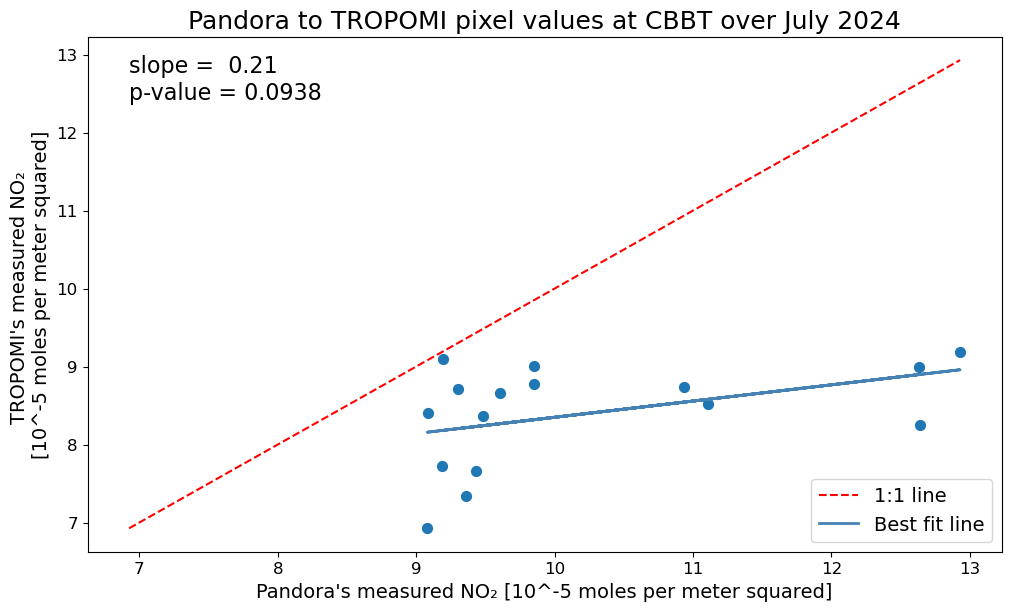

In [31]:
#Compares two of three sites to the other
# Run multiple times to compare all three to each other

x = cleaned['pandora_NO2'] #change as neccessary
y = cleaned['sentinel_NO2'] #change as neccessary
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())

fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# scatter plot of the two variable
ax.scatter(x/10**-5, y/10**-5, s = 50)
#reference 1:1 line
ax.plot([min_val/10**-5, max_val/10**-5], [min_val/10**-5, max_val/10**-5], 'r--', label='1:1 line')

# calculates and plots line of best fit
m, b, r_value, p_value, std_err = linregress(x/10**-5, y/10**-5)
ax.plot(x/10**-5, m*x/10**-5+b, color='steelblue', linewidth=2, label = "Best fit line")
#r_squared = r_value**2

# axis and other final touches
ax.text(min_val/10**-5, (max_val-.000005)/10**-5, 'slope =  ' + '{:.2f}'.format(m) + "\np-value = " + '{:.4f}'.format(p_value), size=16)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_title("Pandora to TROPOMI pixel values at CBBT over July 2024", size = 18)
ax.set_xlabel("Pandora's measured NO₂ [10^-5 moles per meter squared]", size = 14)
ax.set_ylabel("TROPOMI's measured NO₂ \n[10^-5 moles per meter squared]", size = 14)
ax.legend(loc = 'lower right', fontsize = 14)

plt.show()
#plt.savefig('Plots/TROPOMI_Pandora_CBBT_Pixel_to_Point.jpg', dpi=300, bbox_inches='tight')

# HU

In [24]:
# Read in sentinel data from GEE
sentinel_path = '../HULL/Data/TROPOMI_HU_NO2_TimeSeries.csv'
sentinel = pd.read_csv(sentinel_path)

#Clean dataframe
sentinel.drop(columns=['system:index', '.geo'], inplace=True)
sentinel.rename(columns={'NO2':'sentinel_NO2'}, inplace=True)

#test df output
sentinel.head()

,sentinel_NO2,datetime
0,0.000064,2022-07-02 18:31
1,NaN,2022-07-02 18:36
2,NaN,2022-07-03 16:36
3,NaN,2022-07-03 18:11
4,NaN,2022-07-03 18:16


In [25]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = sentinel['sentinel_NO2'].quantile(0.25)
Q3 = sentinel['sentinel_NO2'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers to get a cleaned version
cleaned = sentinel[(sentinel['sentinel_NO2'] >= lower_bound) & (sentinel['sentinel_NO2'] <= upper_bound)]

In [26]:
# read in pandora data
HU_NO2s_filepath = "../HULL/Data/Pandora156s1_HU_L2_NO2s.txt"

#manually typed in names for columns
col_names_NO2s = ["DateTime", "Time since 2000", "Duration of Measurement", "Solar Zenith", "Solar Azimuth", "Lunar Zenith", "Lunar Azimuth", "rms", "normalized rms", "Expected rms",
                   "expected normalized rms", "Climatological station pressure", "data processing type", "calibration file version", "calibration file validity starting date", "mean value of measured data", "wavelength effective temperature", "est avg residual stray light level", "retrieved wavelength shift from L1", "retrieved total wavelength shift",
                   "retrieved resolution change", "integration time", "number of bright count cycles", "effective position of filterwheel #1", "effective position of filterwheel #2", "atmospheric variability", "Estimated AOD at starting wavelength", "Estimated AOD at center wavelength", "Estimated aerosol optical depth at ending wavelength", "L1 quality flag",
                   "Sum over 2^i using those i L1 exceeds the DQ1 limit", "Sum over 2^i using those i L1 exceeds the DQ2 limit", "L2Fit quality flag", "Sum over 2^i using those i L2Fit exceeds the DQ1 limit", "Sum over 2^i using those i L2Fit exceeds the DQ2 limit", "L2 quality flag", "Sum over 2^i using those i L2 exceeds the DQ1 limit", "Sum over 2^i using those i L2 exceeds the DQ2 limit", "NO2 total vertical column amount", "Independent uncertainty of NO2 TC",
                   "Structured uncertainty of NO2 TC", "Common uncertainty of NO2 TC", "total uncertainty of NO2 TC", "rms-based uncertainty of NO2 TC", "NO2 effective temperature", "Independent undertainty of NO2 eff temp", "structured uncertainty of NO2 eff temp", "common uncertainty of NO2 eff temp", "Total uncertainty of NO2 eff temp", "Direct NO2 Air Mass Factor", 
                   "Uncertainty of direct NO2 AMF", "Diffuse correction", "Climatological NO2 stratospheric column amount", "Uncertainty of climatological NO2 strat amount"]

# has special encoding and must skip information rows to get to data
pandora=pd.read_csv(HU_NO2s_filepath, sep = " ",encoding='latin',on_bad_lines='warn', skiprows=77, names=col_names_NO2s)

In [28]:
# loop through to get data from pandora for each datastamp within a +-30min window of an overpass time
mean_TC_list = []
time_sec = []
for doi in sentinel['datetime']:
    j2000_epoch = datetime(2000, 1, 1, 0, 0)
    target_date = datetime.strptime(doi, "%Y-%m-%d %H:%M")
    delta = timedelta(minutes = 30)
    begin = target_date-delta
    end = target_date+delta
    
    # converts to seconds since 1/1/2000, which is what pandora measures in
    begin_seconds = (begin - j2000_epoch).total_seconds() / 86400
    end_seconds = (end - j2000_epoch).total_seconds() / 86400
    
    #select time window
    data = pandora[(pandora.iloc[:, col_names_NO2s.index("Time since 2000")].values >= begin_seconds)&(pandora.iloc[:, col_names_NO2s.index("Time since 2000")].values <= end_seconds)]
    #pulls out just the TC value
    TC = data.iloc[:, [col_names_NO2s.index("NO2 total vertical column amount")]].values
    #finds the mean in that window
    mean_TC = np.nanmean(TC)
    #adds mean and datetime to lists
    mean_TC_list.append(mean_TC)
    time_sec.append((target_date-j2000_epoch).total_seconds()/86400)
    
    
#adds the mean TC for each time as well as the time in seconds to the sentinel df - acting as our combined dataset
sentinel['pandora_NO2'] = mean_TC_list
sentinel['time_sec'] = time_sec

/tmp/ipykernel_302868/583454787.py:20: RuntimeWarning: Mean of empty slice
  mean_TC = np.nanmean(TC)


In [29]:
# Cleans pandora based on IQR
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = sentinel['pandora_NO2'].quantile(0.25)
Q3 = sentinel['pandora_NO2'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Optionally, remove them to get a cleaned version
cleaned = sentinel[(sentinel['pandora_NO2'] >= lower_bound) & (sentinel['pandora_NO2'] <= upper_bound) & (cleaned['sentinel_NO2'] != np.nan)]


cleaned.head()

,sentinel_NO2,datetime,pandora_NO2,time_sec
5,0.000087,2022-07-04 17:56,0.000096,8220.747222
6,0.000085,2022-07-05 17:36,0.000111,8221.733333
13,0.000084,2022-07-08 18:21,0.000095,8224.764583
20,0.000077,2022-07-12 17:06,0.000094,8228.712500
21,0.000088,2022-07-12 18:46,0.000099,8228.781944


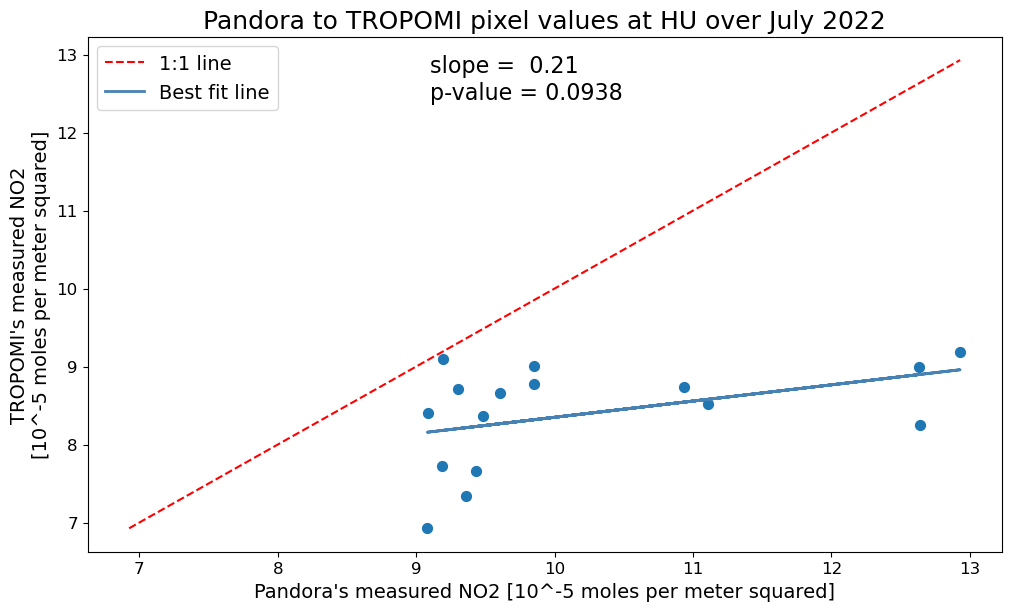

In [33]:
# looks at the two values comparitively
# set x and y variables (usefull if more than two variables are present)
x = cleaned['pandora_NO2']
y = cleaned['sentinel_NO2']
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())

fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
# plots the points against each other

# plot data as well as 1:1 line
ax.scatter(x/10**-5, y/10**-5, s = 50)
ax.plot([min_val/10**-5, max_val/10**-5], [min_val/10**-5, max_val/10**-5], 'r--', label='1:1 line')

# calculates and plots line of best fit 
m, b, r_value, p_value, std_err = linregress(x/10**-5, y/10**-5)
ax.plot(x/10**-5, m*x/10**-5+b, color='steelblue', linewidth=2, label = "Best fit line")
#r_squared = r_value**2

# axis and final touches
#ax.set_xlim(8.9, (max_val + .000005)/10**-5) # used to remove left space in my plot
ax.set_title("Pandora to TROPOMI pixel values at HU over July 2022", size = 18)
ax.set_xlabel("Pandora's measured NO2 [10^-5 moles per meter squared]", size = 14)
ax.set_ylabel("TROPOMI's measured NO2\n[10^-5 moles per meter squared]", size = 14)
ax.text(9.1, (max_val-.000005)/10**-5, 'slope =  ' + '{:.2f}'.format(m) + "\np-value = " + '{:.4f}'.format(p_value), size=16)
ax.legend(fontsize = 14)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plt.show()
#plt.savefig('Plots/TROPOMI_Pandora_HU_Pixel_to_Point.jpg', dpi=300, bbox_inches='tight')

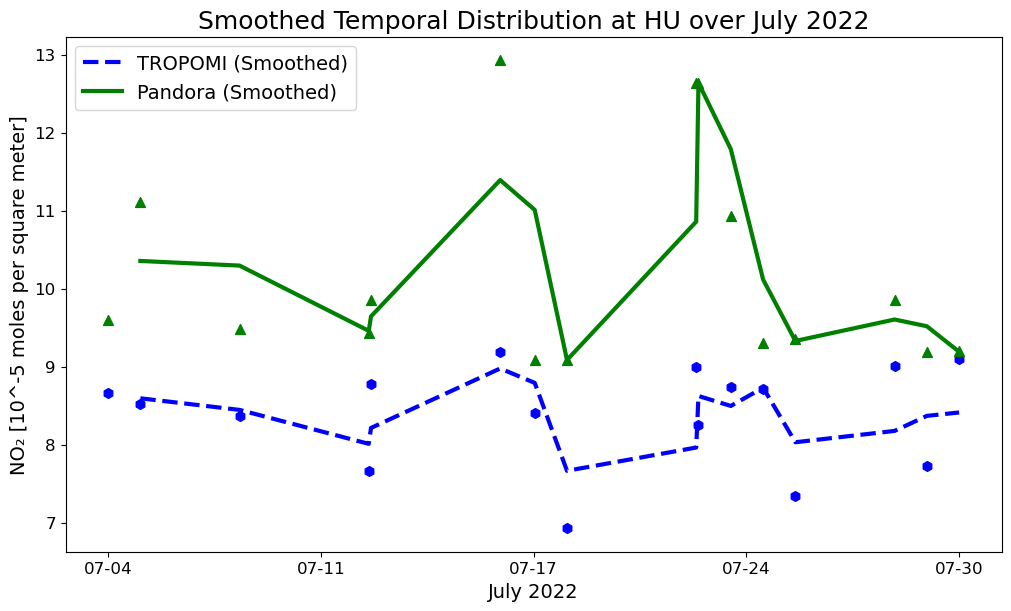

In [30]:
# smoothed temporal distribution
fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)

# scatter the points
ax.scatter(cleaned['time_sec'], cleaned['sentinel_NO2']/10**-5, marker = 'h', color = 'blue', s = 50)
ax.scatter(cleaned['time_sec'], cleaned['pandora_NO2']/10**-5, marker = '^', color = 'green', s = 50)

# rolling window to see patterns
window = 2 # adjust for smoothness
ax.plot(cleaned['time_sec'], (cleaned['sentinel_NO2']/10**-5).rolling(window, center=True).mean(), color='blue', label='TROPOMI (Smoothed)', linestyle = '--', linewidth = 3)
ax.plot(cleaned['time_sec'], (cleaned['pandora_NO2']/10**-5).rolling(window, center=True).mean(), color='green', label='Pandora (Smoothed)', linewidth = 3)

# axis and final touches
ax.set_xticks(np.linspace(cleaned['time_sec'].iloc[0], cleaned['time_sec'].iloc[-1], 5))
ax.set_xticklabels(pd.to_datetime(np.linspace(cleaned['time_sec'].iloc[0], cleaned['time_sec'].iloc[-1], 5) * 86400 + 946684800, unit="s", utc=True).strftime('%m-%d'), size = 12)
ax.set_xlabel("July 2022", size = 14)
ax.set_ylabel("NO₂ [10^-5 moles per square meter]", size = 14)
ax.set_title("Smoothed Temporal Distribution at HU over July 2022", size = 18)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize = 14)

plt.show()
#plt.savefig('Plots/Smoothed_HU_P2P_scatter_July2022.jpg', dpi=300, bbox_inches='tight')